In [1]:
# All libs be imported
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
# All files in src directory
from engine import Engine
from models import UNet, DiffusionLSTM, DiffusionTransformer
from frameworks import Diffusion
from utils import plot_comparison, evaluate_model, visualize_all, plot_loss_comparison, load_checkpoint, plot_series, plot_projection, plot_monte_carlo
from utils.paths import VISUALIZATION_DIR, RESULTS_DIR, RAW_DIR
from ingestion import read_equity, TimeSeriesDataset, SecurityBasketDataset, PortfolioDataset
from preprocessing import to_time_bars, to_volume_bars, to_dollar_bars

VISUALIZATION_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
sp500_index_dataset = SecurityBasketDataset(
    csv_file=os.path.join(RAW_DIR, "sp500_index_2025.csv"),
    start_date="2020-01-01",
    freq="D"
)

In [4]:
dict_assets = sp500_index_dataset.load_assets()

Loading assets for 503 potential symbols...


Reading CSVs: 100%|███████████████████████████| 503/503 [00:18<00:00, 26.73it/s]

Done! Loaded 500 assets. (Missing/Error: 3)


In [6]:
portfolio_dataset = PortfolioDataset(
    assets_dict=dict_assets,
    security_basket_dataset=sp500_index_dataset,
    window_size=64,
    use_timestamp=True,
    use_log_return=True,
    log_return_features=["Close"],
    time_col="Date"
)

Initializing Portfolio with 500 assets...


In [7]:
port_ds_df = portfolio_dataset.scan()

Scanning dataset (2185 time steps)...


Scanning: 100%|████████████████████████████| 2185/2185 [00:04<00:00, 539.57it/s]


--- Scan Complete ---
Total Days: 2185
Ready:      1439 days
Skipped:    746 days (Holiday/No Data)


In [7]:
port_ds_df.head(8)

,Index,Date,Universe,Assets,Status
0,0,2020-01-01,421,0,Skipped
1,1,2020-01-02,421,418,Ready
2,2,2020-01-03,421,418,Ready
3,3,2020-01-04,421,0,Skipped
4,4,2020-01-05,421,0,Skipped
5,5,2020-01-06,421,418,Ready
6,6,2020-01-07,421,418,Ready
7,7,2020-01-08,421,418,Ready


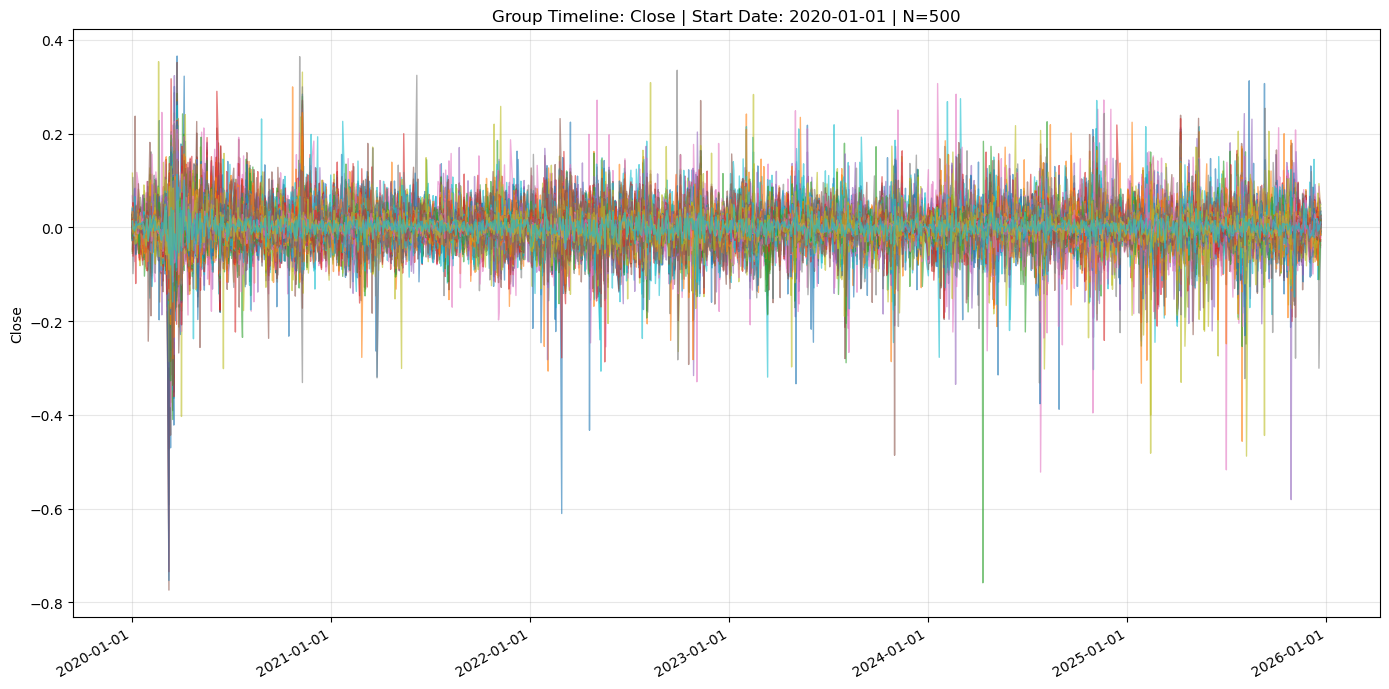

In [8]:
portfolio_dataset.plot_all_assets_timeline(start_index=0, feature="Close")

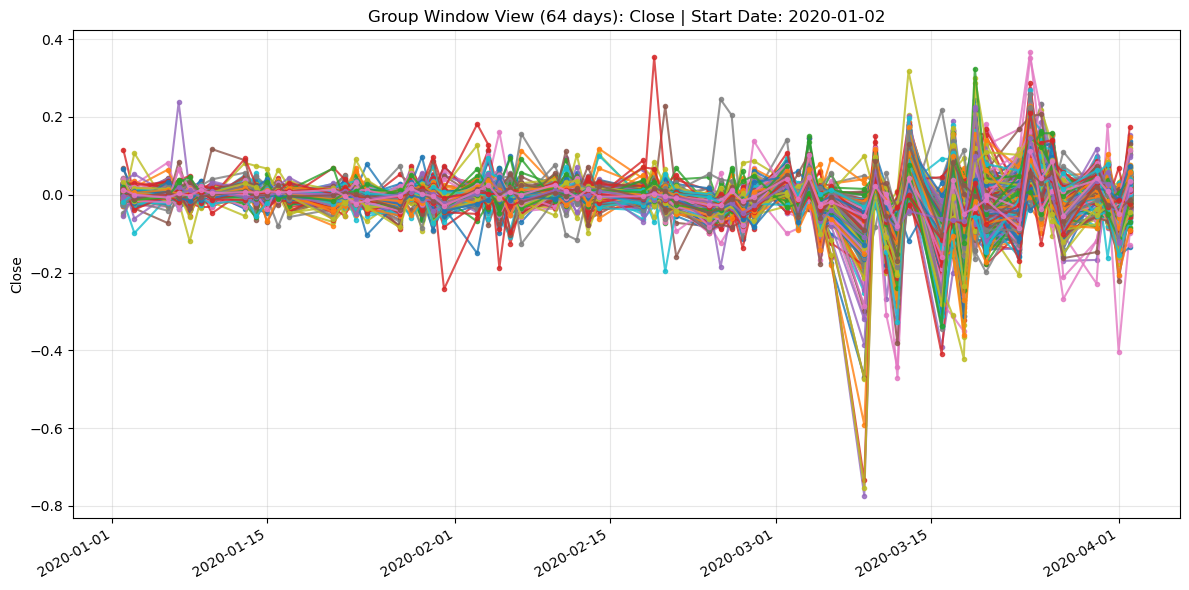

In [13]:
portfolio_dataset.plot_all_assets_window(index=1, feature="Close")

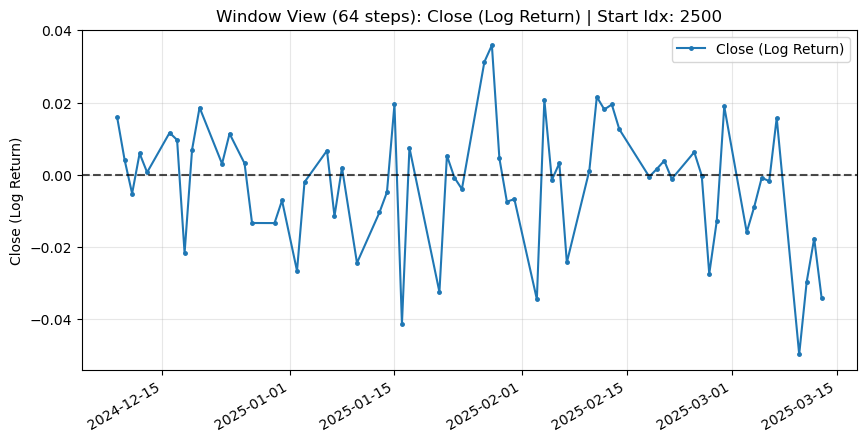

In [10]:
ts_data = portfolio_dataset.asset_datasets['AAPL'] # หรือ new TimeSeriesDataset(...)

# แบบที่ 2: ดูเฉพาะ Window (เช่น start_idx=100 window=60 ก็จะโชว์แค่ช่วงนั้น)
# ถ้าช่วงท้ายข้อมูลขาด กราฟก็จะแหว่งให้เห็นเลยครับ
ts_data.plot_window(start_idx=2500, feature="Close")

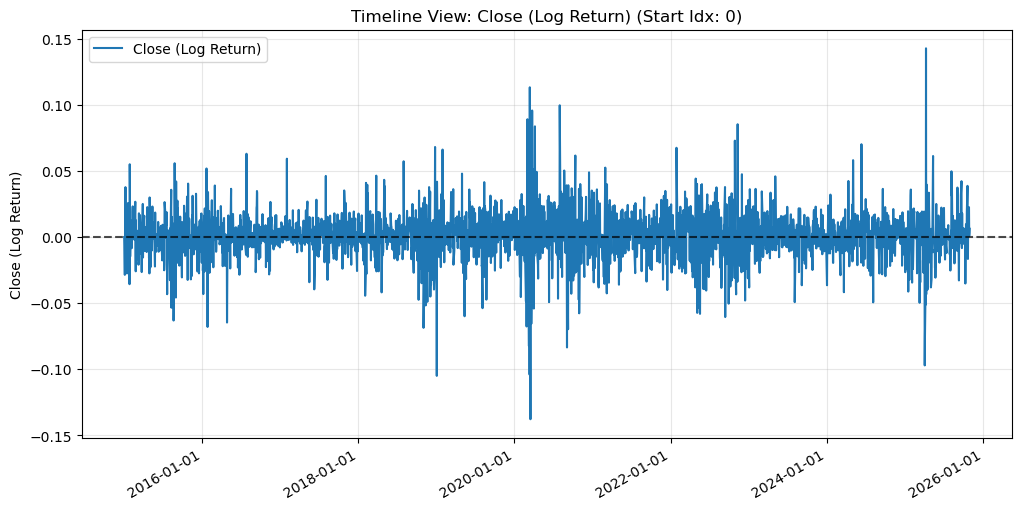

In [11]:
# แบบที่ 1: ดูยาวๆ ตั้งแต่วันที่ 0 ยันปัจจุบัน
ts_data.plot_timeline(start_idx=0, feature="Close")

In [6]:
sp500_index_dataloader = DataLoader(sp500_index_dataset, batch_size=32, shuffle=True)
sp500_index_dataloader